# Q1. Fit and evaluate a NN regression model using real-world data

## Goal: Predict hourly electricity Demand using weather variables and the hour of day

###  1) importing the libraries

In [3]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### 2) importing the dataset

In [4]:
# importing the dataset
url="https://drive.google.com/uc?id=1q7BJ35j3qDeXfuzmZ93qyeYQLaPgYQc6"
df=pd.read_csv(url)
df.head()

,Datetime,Demand,BDL_tmpf,BDL_dwpf,BDL_relh,BDL_drct,BDL_sknt,BDL_p01i,BDL_alti,BDL_mslp,BDL_vsby
0,2019-01-01 00:00:00,2713.617,37.9,37.9,100.0,360.0,4.0,0.0700,29.88,1009.7,5.0
1,2019-01-01 01:00:00,2578.343,37.9,37.9,100.0,360.0,4.0,0.1100,29.79,1006.3,2.0
2,2019-01-01 02:00:00,2467.969,37.9,37.9,100.0,340.0,7.0,0.0100,29.70,1003.3,2.0
3,2019-01-01 03:00:00,2397.140,37.9,37.9,100.0,310.0,6.0,0.0100,29.63,1002.3,1.5
4,2019-01-01 04:00:00,2381.258,37.9,37.9,100.0,140.0,3.0,0.0001,29.58,1001.2,1.5


### 3) inspecting  the data

In [5]:
# Inspecting  data types and missing values
# so beforing going to modeling i am just inscpecting the data and seeing if all the datatypes are correct and if the dataset has any missing values

print('the shape is :',df.shape) # checking the shape that is rows and columns

print("\ndata types:")
print(df.dtypes ) # checking the data types

print("\nThe missing values per colunms :",df.isnull().sum()) # checking for missing values


the shape is : (96427, 11)

data types:
Datetime     object
Demand      float64
BDL_tmpf    float64
BDL_dwpf    float64
BDL_relh    float64
BDL_drct    float64
BDL_sknt    float64
BDL_p01i    float64
BDL_alti    float64
BDL_mslp    float64
BDL_vsby    float64
dtype: object

The missing values per colunms : Datetime      0
Demand        0
BDL_tmpf    267
BDL_dwpf    267
BDL_relh    267
BDL_drct    267
BDL_sknt    267
BDL_p01i    267
BDL_alti    267
BDL_mslp    267
BDL_vsby    267
dtype: int64


### 4)  Create the hour feature from Datetime


In [6]:
# The Datetime column is currently stored as a string (object type).
# Since electricity demand depends strongly on time of day,
# I will:
# 1. Convert Datetime to proper datetime format
# 2. Extract the hour (0–23)
# 3. Use hour as a feature
# 4. I will not  use the raw Datetime column directly

# Converting  Datetime from string to datetime type
df["Datetime"] = pd.to_datetime(df["Datetime"])

# Createing  new column  hour of day
df["hour"] = df["Datetime"].dt.hour

df[["Datetime", "hour"]].head()


,Datetime,hour
0,2019-01-01 00:00:00,0
1,2019-01-01 01:00:00,1
2,2019-01-01 02:00:00,2
3,2019-01-01 03:00:00,3
4,2019-01-01 04:00:00,4


### 5) Selecting modeling columns  and handle missing values

In [7]:
# Now we will select the features and target variables

target="Demand"  # this is the target (y)
feature_cols =["BDL_tmpf", "BDL_dwpf","BDL_relh","BDL_drct","BDL_sknt","hour",]  # this are the features (X)


# i am keeping only required columns
df_model=df[feature_cols+[target]].copy()

# checking missing values for only selected columns
print("\n Missing values before cleaning ;")
print(df_model.isna().sum())

# Droping the rows with missing values
df_model=df.dropna()

print("\nShape after droping the missing rows:",df_model.shape)

# now i am seperating the X and Y
X=df_model[feature_cols]
y=df_model[target]





 Missing values before cleaning ;
BDL_tmpf    267
BDL_dwpf    267
BDL_relh    267
BDL_drct    267
BDL_sknt    267
hour          0
Demand        0
dtype: int64

Shape after droping the missing rows: (96160, 12)


### we can see that the shape has changed after creating the new feature and droping the missing values

### 6)  Train / Validation split

In [9]:
# Now that the data is clean, I will split it into;
#  80% training data that is  used to train the neural network
# 20% validation data thatis  used to evaluate performance

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

X_train shape: (76928, 6)
X_val shape: (19232, 6)


* I split the dataset into training and validation sets so the model can learn on one portion of the data and be tested on unseen data.  
* This helps me evaluate whether the neural network generalizes well instead of memorizing the training data.

###7) Scale the features (StandardScaler)

In [10]:
# In this step:
#  I fit the scaler using only X_train (to avoid data leakage)
#  Then I transform both X_train and X_val using the same scaler

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

 # Fitting only on training data, then transform train and validation
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# checking for  shapes  because it should remain the same
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)

X_train_scaled shape: (76928, 6)
X_val_scaled shape: (19232, 6)


### 8) Building the Neural Network

In [14]:
import tensorflow as tf

# Now I will build a neural network regression model to predict electricity demand.

# I include:
# Multiple Dense layers to learn nonlinear patterns
# Dropout layers to reduce overfitting
# EarlyStopping to stop training when validation loss stops improving and restore the best weights


# I am using a Sequential model because the layers are stacked one after another
model = tf.keras.Sequential([

    # First hidden layer

    # 64 neurons to learn many patterns from the 6 input features
    # ReLU activation helps the network learn non linear relationships
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),

    # Dropout randomly turns off 30% of neurons during training
    # This helps reduce overfitting
    tf.keras.layers.Dropout(0.3),


    # Second hidden layer

    # Fewer neurons (32) to gradually compress information
    tf.keras.layers.Dense(32, activation='relu'),

    # Dropout again to improve generalization
    tf.keras.layers.Dropout(0.3),


    # Third hidden layer

    # Even smaller layer (16 neurons) before final prediction
    tf.keras.layers.Dense(16, activation='relu'),

    tf.keras.layers.Dropout(0.2),


    # Output layer
    # Only 1 neuron because this is regression (predicting one number: Demand)
    # Linear activation is used for regression problems
    tf.keras.layers.Dense(1, activation='linear')
])




# Adam optimizer → works well for most deep learning problems
# MSE loss → standard loss for regression tasks
model.compile(
    optimizer='adam',
    loss='mse'
)


# Print model architecture summary
model.summary()



# Early Stopping

# Stop training if validation loss does not improve for 10 epochs
# restore_best_weights=True ensures we keep the best model
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)



# Train the modeL

# epochs=200 maximum training rounds (may stop earlier due to early stopping)
# batch_size=32 = number of samples per gradient update
# validation_data =used to evaluate generalization
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 4517123.0000 - val_loss: 263050.5625
Epoch 2/200
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 859432.6250 - val_loss: 233569.6719
Epoch 3/200
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 792193.8125 - val_loss: 222540.7812
Epoch 4/200
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 779677.9375 - val_loss: 227166.4062
Epoch 5/200
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 760425.8750 - val_loss: 212460.1719
Epoch 6/200
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 768270.5000 - val_loss: 207907.6562
Epoch 7/200
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 744226.0000 - val_loss: 216514.6562
Epoch 8/200
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 731196.2500 - val_loss: 214183.2969
Epoch 9/200
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 723384.3125 - val_loss: 231374.4844
Epoch 10/200
2404/2404 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 719536.8125 - val_loss: 227066.4688
Epoch 11

### 9) Learning Curve Plot
*  (Train loss vs Validation loss)

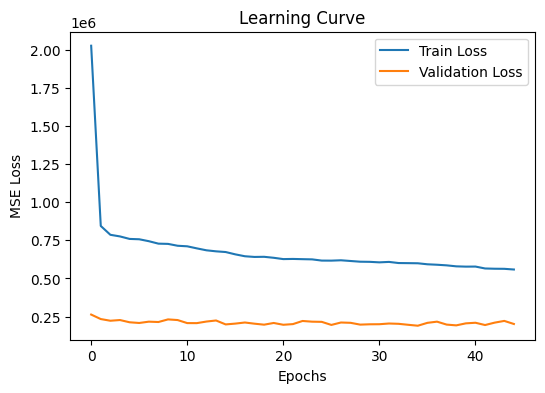

In [15]:
# Ploting the the learning curve

# After training, I plot the training loss and validation loss over epochs.

# This helps me:
# see if the model is learning
# check for overfitting
# compare train vs validation performance

# Ploting  training loss vs validation loss

plt.figure(figsize=(6,4))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Learning Curve')
plt.legend()

plt.show()


* From the learning curve, both training and validation losses decrease steadily, which shows the model is learning useful patterns.

* The validation loss remains stable and does not increase, indicating that the model is not overfitting. The slightly lower validation loss is expected because dropout is only applied during training.


### 10) Predictions
###

Now I use the trained model to predict electricity demand on both the training and validation sets so I can evaluate performance.


In [16]:
# Predictions

y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)


2404/2404 ━━━━━━━━━━━━━━━━━━━━ 2s 696us/step
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step


### 11) Calculate Metrics (MAE, RMSE, R²)

To evaluate the regression model,
I calculate:
- MAE
- RMSE
- R² score

I compute these metrics for both training and validation sets.

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

#  Validation metrics
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)


print("Train Metrics")
print("MAE :", train_mae)
print("RMSE:", train_rmse)
print("R2  :", train_r2)

print("\nValidation Metrics")
print("MAE :", val_mae)
print("RMSE:", val_rmse)
print("R2  :", val_r2)


Train Metrics
MAE : 356.25409503755236
RMSE: 436.8682668191407
R2  : 0.6717393790408284

Validation Metrics
MAE : 355.55106358949274
RMSE: 435.775224211789
R2  : 0.6694340254334143


## Model Performance Interpretation

- The training and validation metrics are very similar, which indicates that the model generalizes well and is not overfitting.

- The MAE of about 356 means the predictions are off by roughly 356 units of demand on average, which is reasonable compared to the overall demand range.

- The R² score of around 0.67 shows that the neural network explains about 67% of the variability in electricity demand, which is a good result for real  weather data


### 12) Scatter Plot (Actual vs Predicted)*italicized text*

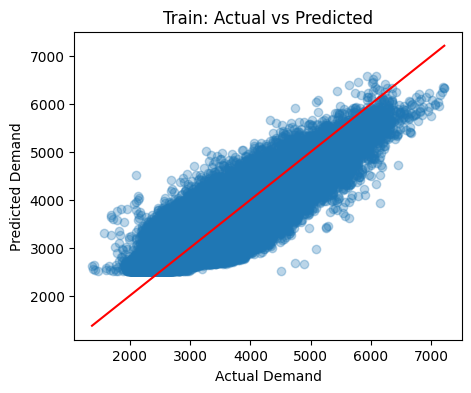

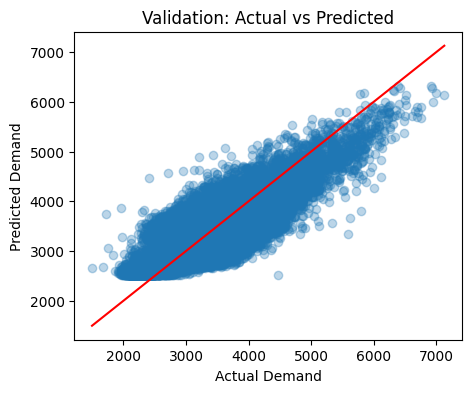

In [18]:
# To visually evaluate the model, I plot actual demand values against predicted values.

# If the model performs well:
#  points should lie close to the diagonal line
#  predictions should match actual values

# I create separate plots for training and validation sets


# Scatter plot: Training data


plt.figure(figsize=(5,4))

plt.scatter(y_train, y_train_pred, alpha=0.3)

plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Train: Actual vs Predicted")

# perfect prediction line
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         'r')

plt.show()




# Scatter plot: Validation data

plt.figure(figsize=(5,4))

plt.scatter(y_val, y_val_pred, alpha=0.3)

plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Validation: Actual vs Predicted")

plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         'r')

plt.show()


- The training scatter plot shows points closely following the diagonal line, indicating that the model fits the training data well.
- The validation scatter plot shows a similar diagonal pattern, which confirms that the model generalizes well and does not overfit.
